In [1]:
from tqdm.notebook import tqdm as tqm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np

# Opciones de matplotlib
rc=plt.rcParams
rc['figure.figsize']=[15,5]

# Para mostrar todas las columnas cuando se imprime un df
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

La cadena de Ehrenfest modela una caja con un gas libre con una pequeña compuerta de tal forma que en cada paso solo una partícula pasa de un lugar a otro

Entonces la matriz de transición está dada por

$$
P=
\begin{pmatrix}
0 & 1 & 0 & 0 & 0 &\cdots 0& 0&0\\
\frac{1}{d} &0 & \frac{d-1}{d} & 0  &0& \cdots 0& 0& 0\\
0 & \frac{2}{d} & 0 & \frac{d-2}{d} & 0 &\cdots 0&0 & 0\\
\vdots & \vdots &\vdots & \vdots & \vdots & \ddots & \vdots\\
0 & 0 & 0 & 0 & 0 &\cdots \frac{d-1}{d}& 0&\frac{1}{d}\\
0 & 0 & 0 & 0 & 0 &\cdots 0& 1&0\\
\end{pmatrix}
$$

Como haríamos para simular esta cadena?

Sabemos que la probabilidad de ir en n pasos a otra posición está dada por:
$$\mathbb{P}\left[X_n=j,X_0=i\right]={P^n}_{ij}$$

Entonces si primero fijamos (o ponemos una distribución) para $X_0$, (poner $X_0$ fijo es ponerle una distribución con un 1 en un valor) podemos encontrar la distribución del n-ésimo paso usando

$$\vec{\pi}_{n}=\vec{\pi}_0\cdot {P^n}$$

In [45]:
from math import factorial as fact

def gen_mat_Ehrenfest(d):
    P=np.zeros(shape=(d,d))
    for i in range(1,d-1):
        P[i,i+1]=(d-i-1)/(d-1)
        P[i,i-1]=i/(d-1)
    P[0,1]=1
    P[d-1,d-2]=1
    return P

d=4
P=gen_mat_Ehrenfest(d+1)
for pi in P:
    print([f'{round(pii,2):2.3f}' for pii in pi])

['0.000', '1.000', '0.000', '0.000', '0.000']
['0.250', '0.000', '0.750', '0.000', '0.000']
['0.000', '0.500', '0.000', '0.500', '0.000']
['0.000', '0.000', '0.750', '0.000', '0.250']
['0.000', '0.000', '0.000', '1.000', '0.000']


In [63]:
def matriz_potencia(P,potencia):
    for _ in range(potencia-1):
        P=P @ P
        P=P/(P.sum(axis=1).reshape(-1,1)) # Por errores de redondeo
    return P

matriz_potencia(P,7)

array([[0.125, 0.   , 0.75 , 0.   , 0.125],
       [0.   , 0.5  , 0.   , 0.5  , 0.   ],
       [0.125, 0.   , 0.75 , 0.   , 0.125],
       [0.   , 0.5  , 0.   , 0.5  , 0.   ],
       [0.125, 0.   , 0.75 , 0.   , 0.125]])

In [47]:
def distr_bin_pmf(k,N,p=1/2):
    coef_binom=fact(N)/(fact(N-k)*fact(k))
    
    return coef_binom*p**k*(1-p)**(N-k)

pi_binom=np.zeros(d+1)

for k in range(d+1):
    pi_binom[k]=distr_bin_pmf(k,d)

print(pi_binom)
print(pi_binom.sum())


[0.0625 0.25   0.375  0.25   0.0625]
1.0


In [50]:
Pn=matriz_potencia(P,10)
pi_binom@Pn

array([0.0625, 0.25  , 0.375 , 0.25  , 0.0625])

# Problema 4

In [212]:
P=np.array([[0.4,0.3,0.3],[0.3,0.2,0.5],[0.7,0,0.3]])

P

array([[0.4, 0.3, 0.3],
       [0.3, 0.2, 0.5],
       [0.7, 0. , 0.3]])

In [213]:
pi_0=np.array([1,0,0])


pi_1=pi_0@P
print(pi_1)

[0.4 0.3 0.3]


Como le hago para simular de esta distribución?

Viendo en qué cuadrado cae

In [35]:
u=np.random.random()
print(u)

0.7973708007598989


In [38]:
pi_1.cumsum()

array([0.4, 0.7, 1. ])

In [37]:
mask=u<=pi_1.cumsum()
mask

array([False, False,  True])

el valor de la uniforme cae en el cuadrado que tenga true

In [78]:
x_1=mask.argmax()
x_1

2

Simulando la cadena completa

In [228]:
def simular_de_array_proba(array_proba):
    u=np.random.random()
    array_proba_acum=array_proba.cumsum()

    mask=u<=array_proba_acum
    
    indice=mask.argmax()

    return indice

def paso_siguiente(Xn):
    array_xn=np.zeros(3)
    array_xn[Xn]=1
    pi_n_mas_1=array_xn@P
    
    return simular_de_array_proba(pi_n_mas_1)


paso_siguiente(Xn=0)


0

(0.0, 100.0)

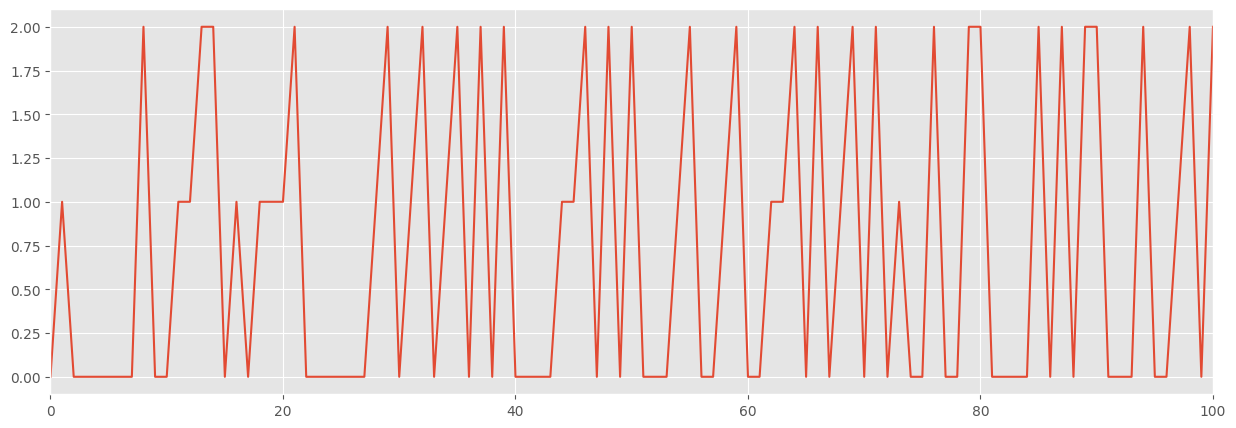

In [234]:
Xn=[0]
long_cadena=100

for _ in range(long_cadena):
    # print(Xn[-1],Xn)
    Xn.append(paso_siguiente(Xn[-1]))


plt.plot(Xn)
plt.xlim(0,100)

Veamos el promedio de pasos en los que regreso del 0 al 0

In [239]:
print(np.array(Xn)==0)
print((np.array(Xn)==0).cumsum())
(np.array(Xn)==0).cumsum()/np.arange(1,len(Xn)+1)

[ True False  True  True  True  True  True  True False  True  True False
 False False False  True False  True False False False False  True  True
  True  True  True  True False False  True False False  True False False
  True False  True False  True  True  True  True False False False  True
 False  True False  True  True  True False False  True  True False False
  True  True False False False  True False  True False False  True False
  True False  True  True False  True  True False False  True  True  True
  True False  True False  True False False  True  True  True False  True
  True False False  True False]
[ 1  1  2  3  4  5  6  7  7  8  9  9  9  9  9 10 10 11 11 11 11 11 12 13
 14 15 16 17 17 17 18 18 18 19 19 19 20 20 21 21 22 23 24 25 25 25 25 26
 26 27 27 28 29 30 30 30 31 32 32 32 33 34 34 34 34 35 35 36 36 36 37 37
 38 38 39 40 40 41 42 42 42 43 44 45 46 46 47 47 48 48 48 49 50 51 51 52
 53 53 53 54 54]


array([1.        , 0.5       , 0.66666667, 0.75      , 0.8       ,
       0.83333333, 0.85714286, 0.875     , 0.77777778, 0.8       ,
       0.81818182, 0.75      , 0.69230769, 0.64285714, 0.6       ,
       0.625     , 0.58823529, 0.61111111, 0.57894737, 0.55      ,
       0.52380952, 0.5       , 0.52173913, 0.54166667, 0.56      ,
       0.57692308, 0.59259259, 0.60714286, 0.5862069 , 0.56666667,
       0.58064516, 0.5625    , 0.54545455, 0.55882353, 0.54285714,
       0.52777778, 0.54054054, 0.52631579, 0.53846154, 0.525     ,
       0.53658537, 0.54761905, 0.55813953, 0.56818182, 0.55555556,
       0.54347826, 0.53191489, 0.54166667, 0.53061224, 0.54      ,
       0.52941176, 0.53846154, 0.54716981, 0.55555556, 0.54545455,
       0.53571429, 0.54385965, 0.55172414, 0.54237288, 0.53333333,
       0.54098361, 0.5483871 , 0.53968254, 0.53125   , 0.52307692,
       0.53030303, 0.52238806, 0.52941176, 0.52173913, 0.51428571,
       0.52112676, 0.51388889, 0.52054795, 0.51351351, 0.52   

(0.0, 1.0)

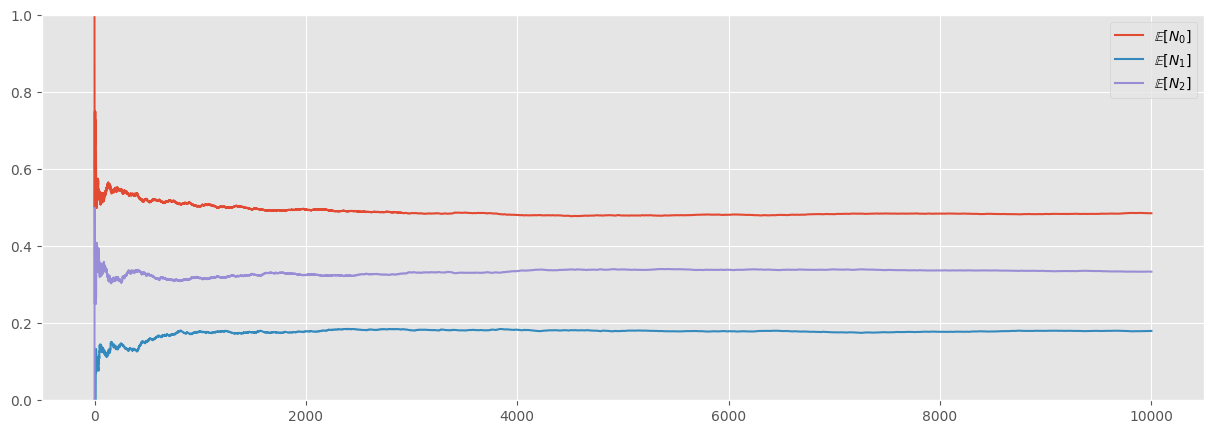

In [104]:
plt.plot((np.array(Xn)==0).cumsum()/np.arange(1,len(Xn)+1),label='$\\mathbb{E}[N_0]$')
plt.plot((np.array(Xn)==1).cumsum()/np.arange(1,len(Xn)+1),label='$\\mathbb{E}[N_1]$')
plt.plot((np.array(Xn)==2).cumsum()/np.arange(1,len(Xn)+1),label='$\\mathbb{E}[N_2]$')
plt.legend()
plt.ylim(0,1)

Cómo podríamos hacer para que tuviera un estado absorbente y por lo tanto un estado transitorio? 

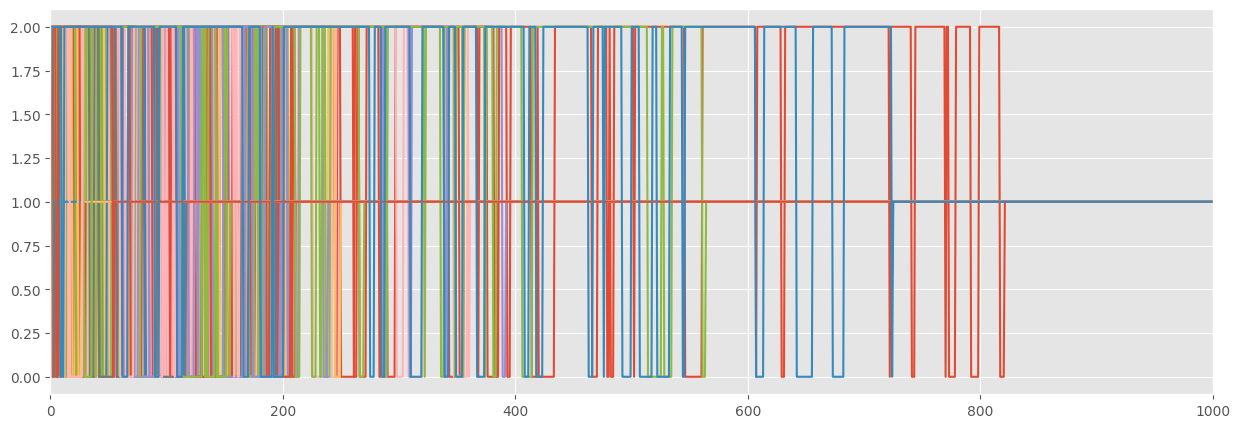

In [124]:
P=np.array([
       [0.8,0.2/5, 4*0.2/5],
       [0, 1, 0],
       [0.05, 0. , 0.95]])




for i in range(100):
       Xn=[2]
       long_cadena=10_000

       for _ in range(long_cadena):
              Xn.append(paso_siguiente(Xn[-1]))
       plt.plot(Xn)
       plt.xlim(0,1000)

Cómo se vería el promedio de veces que se visita cada estado conforme avanza el tiempo?

(0.0, 1.0)

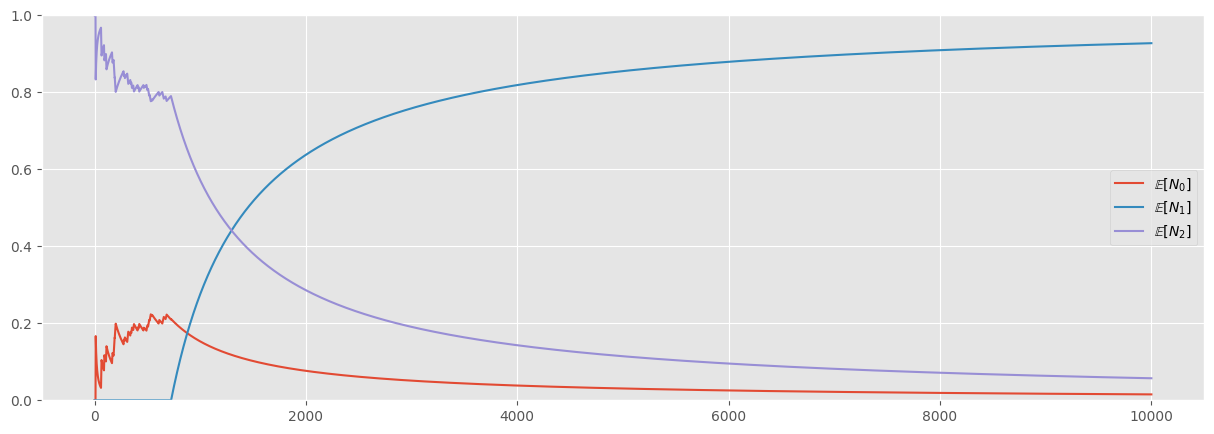

In [125]:
plt.plot((np.array(Xn)==0).cumsum()/np.arange(1,len(Xn)+1),label='$\\mathbb{E}[N_0]$')
plt.plot((np.array(Xn)==1).cumsum()/np.arange(1,len(Xn)+1),label='$\\mathbb{E}[N_1]$')
plt.plot((np.array(Xn)==2).cumsum()/np.arange(1,len(Xn)+1),label='$\\mathbb{E}[N_2]$')
plt.legend()
plt.ylim(0,1)

# Problema 8

Podemos usar que están comunicados si existe un $n>0$ tal que $$P^n(x,y)>0$$

In [ ]:
np.array([[]])